In [1]:
import os
from glob import glob
import random  # funciones aleatorias

from itertools import islice as take  # tomar n elementos de una secuencia

# audio
import librosa
import librosa.display

# gráficas
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")

# DS basics
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import label_ranking_average_precision_score

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# redes audio
import torchaudio
import torchaudio.transforms as T

# utilidades pytorch
from torch.utils.data import DataLoader

from torchinfo import summary  # inspección de arquitectura

from tqdm import trange, tqdm # barras de progreso


In [2]:
# Alguna constantes
NUM_SPECIES = 24

SAMPLE_RATE = 22050
N_FFT = 400

dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_per_process_memory_fraction(0.6)
dev

device(type='cuda', index=0)

# Lectura de datos

In [3]:
# Definiendo algunas rutas
data_dir = '../datos'
train_audios_dir = os.path.join(data_dir,"train2")
test_audios_dir = os.path.join(data_dir,"test2")

train_files_paths = glob(os.path.join(train_audios_dir, "*.flac"))
test_files_paths = glob(os.path.join(test_audios_dir, "*.flac"))

df_train = pd.read_csv("../datos/augmented_train_long.csv")
df_train

,recording_id,species_id,t_min,t_max,f_min,f_max,is_tp,duration,bandwidth
0,00204008d,4,15.0027,16.8587,2343.7500,4218.7500,False,1.8560,1875.0000
1,00204008d,8,24.4960,28.6187,3750.0000,5531.2500,False,4.1227,1781.2500
2,00204008d,21,13.8400,14.9333,3281.2500,4125.0000,False,1.0933,843.7500
3,003b04435,22,43.2533,44.8587,10687.5000,13687.5000,False,1.6054,3000.0000
4,003b04435,23,9.1254,15.2091,7235.1562,11283.3984,False,6.0837,4048.2422
...,...,...,...,...,...,...,...,...,...
10937,ffb8d8391_rolled,5,15.3467,17.6987,4781.2500,10406.2000,True,2.3520,5624.9500
10938,ffb8d8391_pitch-shifted,5,14.3467,16.6987,NaN,NaN,True,2.3520,NaN
10939,ffb9a7b9a_gaussian_noise,18,40.3200,41.0133,3187.5000,5062.5000,True,0.6933,1875.0000
10940,ffb9a7b9a_rolled,18,35.3200,36.0133,3187.5000,5062.5000,True,0.6933,1875.0000


In [4]:
audio_path = os.path.join(train_audios_dir, "00204008d.flac")
audio_path

'../datos/train2/00204008d.flac'

In [5]:
%%time
audio, sr = librosa.load(audio_path, mono=False)
sr

CPU times: user 13 ms, sys: 4.31 ms, total: 17.3 ms
Wall time: 235 ms


22050

In [6]:
%%time
audio, sr = torchaudio.load(audio_path)
sr

CPU times: user 20 ms, sys: 3.97 ms, total: 23.9 ms
Wall time: 354 ms


22050

Como sería el transform:
* Espectrograma
    * Espectrograma normal
    * Escala de MEL
    
* Amplitud a decibel

In [7]:
class AudioTransform:
    def __init__(self, spec_type, **spec_kwargs):
        tsfm = []
        
        n_fft = spec_kwargs.get("n_fft", N_FFT)
        n_time_bins = SAMPLE_RATE*60//(n_fft//2) + 1
        if spec_type == "spec":
            tsfm.append(T.Spectrogram(**spec_kwargs))
            self.output_shape = n_fft//2 + 1,  n_time_bins
        elif spec_type == "mel":
            tsfm.append(T.MelSpectrogram(**spec_kwargs))
            self.output_shape = spec_kwargs.get("n_mels", 128), n_time_bins
        else:
            raise ValueError("f{spec_type} no es válido")
            
        tsfm.append(T.AmplitudeToDB())
        
        self.tsfm = nn.Sequential(*tsfm)
        
    def __call__(self, X):
        return self.tsfm(X)
        

In [8]:
class RcsaDataset:
    def __init__(self, paths, df=None, spec_type="spec", **spec_kwargs):
        self.paths = paths
        self.df = df
        self.tsfm = AudioTransform(spec_type, **spec_kwargs)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # Identificación del audio
        path = self.paths[idx]
        filename = os.path.basename(path)
        recording_id, _ = os.path.splitext(filename)
        
        # Leyendo audio
        audio_pt, sr = torchaudio.load(path)
        espectrograma = self.tsfm(audio_pt)
        
        ejemplo = {"audio": audio_pt, "spectrogram": espectrograma}
        
        if self.df is not None:  # Creación del vector de etiquetas
            df_recording = self.df.query("recording_id == @recording_id")
            y = -torch.ones(NUM_SPECIES)
            for row in df_recording.itertuples(index=False):
                y[row.species_id] = int(row.is_tp)
                
            ejemplo["label"] = y
        
        return ejemplo

In [9]:
len(train_files_paths)

7034

In [10]:
train_paths, val_paths = train_test_split(train_files_paths, test_size=0.2, random_state=42)

# Esquema de entrenamiento

In [11]:
class MultiLabelBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss(reduction="sum")
        
    def forward(self, Y_input, Y_target):
        """y_target {-1,0,1}"""
        batch_size = Y_input.size(0)
        Y_target = Y_target.float()
        
        loss = 0
        n = 0
        for i in range(batch_size):
            y_input = Y_input[i, :]
            y_target = Y_target[i, :]
            
            y_true = y_target[y_target != -1]
            y_pred = y_input[y_target != -1]
            n += torch.sum(y_target != -1)
            loss += self.bce(y_pred, y_true)
            
        return loss/n


def train_epoch(dl, model, loss_f, opt, device):
    for batch in dl:
        opt.zero_grad()  # vaciamos los gradientes

        x = batch["spectrogram"].to(device)
        y_true = batch["label"].to(device)

        y_lgts = model(x)
        y_out = torch.sigmoid(y_lgts)

        loss = loss_f(y_out, y_true)  # computamos la pérdida

        loss.backward()  # retropropagamos
        opt.step()  # actualizamos parámetros


def eval_epoch(dl, model, loss_f, device, num_batches=None):
    with torch.no_grad():
        # historiales
        losses, lraps = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch["spectrogram"].to(device)
            y_true = batch["label"].to(device)

            y_lgts = model(x)
            y_out = torch.sigmoid(y_lgts)
            
            loss = loss_f(y_out, y_true)  # computamos la pérdida

            # computamos LRAP
            ceros = torch.zeros( *y_out.size() ).to(device)
            lrap = label_ranking_average_precision_score(
                torch.where(y_true == 1, 1., 0.).cpu().numpy(),
                y_out.cpu().numpy()
            )

            # guardamos históricos
            losses.append(loss.item())
            lraps.append(lrap)

        # promediamos
        loss = np.mean(losses)
        lrap = np.mean(lraps)

        return loss, lrap
    

def save_check_point(model, epoch, filename):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        },
        os.path.join("../checkpoints", filename+".pth")
    )
        
        
def train(model, trn_dl, tst_dl, lr=1e-4, epochs=20,
          trn_batches=None, tst_batches=None, model_name="model"):

    loss_hist, lrap_hist = [], []  # historiales
    loss_f = MultiLabelBCELoss()
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)
    
    # Usamos GPU, de ser posible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_lrap = 0
    for epoch in trange(epochs):
        # modelo en modo de entrenamiento
        model.train()
        train_epoch(trn_dl, model, loss_f, opt, device)

        # modelo en modo de evaluación
        model.eval()
        trn_loss, trn_lrap = eval_epoch(trn_dl, model, loss_f, device, trn_batches)
        tst_loss, tst_lrap = eval_epoch(tst_dl, model, loss_f, device, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        lrap_hist.append([trn_lrap, tst_lrap])
        
        if tst_lrap > best_lrap:
            best_lrap = tst_lrap
            save_check_point(model, epoch, model_name)

    return loss_hist, lrap_hist


def plot(loss_hist, lrap_hist, c="black", name = None):
    epocas = np.arange(1, len(loss_hist)+1)
    trn_loss, tst_loss = zip(*loss_hist)
    trn_lrap, tst_lrap = zip(*lrap_hist)
    fig, ax = plt.subplots(1,2, figsize=(13,5))

    ax[0].plot(epocas, trn_loss, label='train')
    ax[0].plot(epocas, tst_loss, label='test')
    ax[0].set_ylabel("Pérdida", fontsize = 25, color = c)
    
    ax[1].plot(epocas, trn_lrap, label='train')
    ax[1].plot(epocas, tst_lrap, label='test')
    ax[1].set_ylabel("LRAP", fontsize = 25, color = c)
    for i in range(2):
        ax[i].set_xlabel('Época', fontsize = 25, color = c)
        ax[i].legend(loc='upper left')
        ax[i].tick_params(axis='both', labelsize=20, color=c, labelcolor=c)
        
        # spines
        ax[i].spines["left"].set_color(c)
        ax[i].spines["bottom"].set_color(c)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["top"].set_visible(False)
        
    if name:
        fig.savefig(f"../figs/{name}.png", transparent = True, bbox_inches = "tight")


# Modelo 

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, M, pool_size):
        super().__init__()
        self.kernel_size = (M, 3)
        self.pool_size = pool_size
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_size),
            nn.Dropout(p=0.5)
        )
        
    def forward(self, X):
        return self.cnn(X)
    
    def get_output_shape(self, *img_shape):
        kernel_size = self.kernel_size
        
        pool_size = self.pool_size
        if isinstance(pool_size, int):
            pool_size = pool_size, pool_size

        *_, H_in, W_in = img_shape    
            
        H_conv = int(H_in - kernel_size[0] + 1)
        W_conv = int(W_in - kernel_size[1] + 1)
        
        H_pool = int((H_conv - pool_size[0])/pool_size[0] + 1)
        W_pool = int((W_conv - pool_size[1])/pool_size[1] + 1)
        
        return H_pool, W_pool
            
        
class Conv(nn.Module):
    def __init__(self, M=3, spec_shape=(201, 6616), fc_features=800):
        super().__init__()
        
        out_channels_list = [20, 40, 60]
        in_channels_list = [1] + out_channels_list[:-1]
        conv_blocks = [ConvBlock(in_channels, out_channels, M, pool_size=2) 
                       for in_channels, out_channels in zip(in_channels_list, out_channels_list)]
        self.cnn = nn.Sequential(
            *conv_blocks
        )
        
        # Determinando dimensiones después de la convolución
        H_out, W_out = spec_shape
        for conv_block in conv_blocks:
            H_out, W_out = conv_block.get_output_shape(H_out, W_out)
        
        out_channels = out_channels_list[-1]
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels*H_out*W_out, fc_features),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_features, NUM_SPECIES)
        )
        
    def forward(self, X):
        X = self.cnn(X)
        #print(X.shape)
        y = self.fc(X)
        return y
    
    

## Usando espectrogramas

In [13]:
# Datasets con espectrogramas "normales"
train_dataset = RcsaDataset(train_paths, df_train, spec_type="spec")
val_dataset = RcsaDataset(val_paths, df_train, spec_type="spec")

spec_shape = train_dataset.tsfm.output_shape

# Dataloaders
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

modelo_spec = Conv(3, spec_shape, fc_features=256)
modelo_spec

Conv(
  (cnn): Sequential(
    (0): ConvBlock(
      (cnn): Sequential(
        (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
    (1): ConvBlock(
      (cnn): Sequential(
        (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
    (2): ConvBlock(
      (cnn): Sequential(
        (0): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1138500, out_features=256, bias=True)
    (2): ReLU()
    (3)

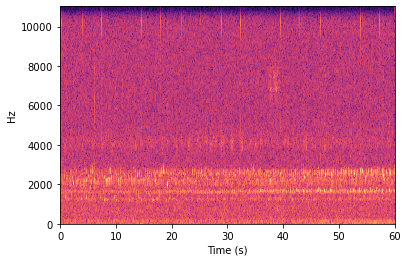

In [24]:
ejemplo = train_dataset[0]
data = ejemplo["spectrogram"][0,:,:].numpy()
librosa.display.specshow(data, hop_length=200, y_axis="linear", x_axis="s")

In [14]:
input_shape = (1,1) + spec_shape
summary(modelo_spec, input_shape, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     --                        --
├─Sequential: 1-1                        [1, 60, 23, 825]          --
│    └─ConvBlock: 2-1                    [1, 20, 99, 3307]         --
│    │    └─Sequential: 3-1              [1, 20, 99, 3307]         200
│    └─ConvBlock: 2-2                    [1, 40, 48, 1652]         --
│    │    └─Sequential: 3-2              [1, 40, 48, 1652]         7,240
│    └─ConvBlock: 2-3                    [1, 60, 23, 825]          --
│    │    └─Sequential: 3-3              [1, 60, 23, 825]          21,660
├─Sequential: 1-2                        [1, 24]                   --
│    └─Flatten: 2-4                      [1, 1138500]              --
│    └─Linear: 2-5                       [1, 256]                  291,456,256
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─Dropout: 2-7                      [1, 256]                  -

Sat Jun 12 05:30:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 206...  Off  | 00000000:01:00.0  On |                  N/A |
| 52%   45C    P8    16W / 184W |    189MiB /  7979MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

100%|██████████| 5/5 [2:08:24<00:00, 1540.95s/it]


[0.6566201729447998, 0.6296657986111112]

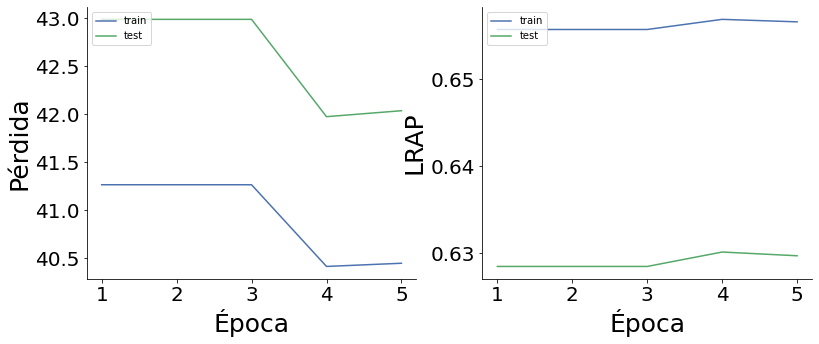

In [15]:
!nvidia-smi

loss_hist, lrap_hist = train(modelo_spec, train_dataloader, val_dataloader, 
                             lr=1e-3, epochs=5, model_name="conv-spec")

plot(loss_hist, lrap_hist, name="conv-spec")
lrap_hist[-1]

## Usando mel

In [12]:
# Datasets con espectrogramas "normales"
train_dataset = RcsaDataset(train_paths, df_train, spec_type="mel", n_mels=64)
val_dataset = RcsaDataset(val_paths, df_train, spec_type="mel", n_mels=64)

spec_shape = train_dataset.tsfm.output_shape

# Dataloaders
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

modelo_mel = Conv(3, spec_shape, fc_features=256)
modelo_mel

Conv(
  (cnn): Sequential(
    (0): ConvBlock(
      (cnn): Sequential(
        (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
    (1): ConvBlock(
      (cnn): Sequential(
        (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
    (2): ConvBlock(
      (cnn): Sequential(
        (0): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=297000, out_features=256, bias=True)
    (2): ReLU()
    (3):

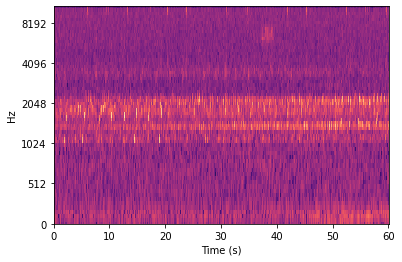

In [26]:
ejemplo = train_dataset[0]
data = ejemplo["spectrogram"][0,:,:].numpy()
librosa.display.specshow(data, hop_length=200, y_axis="mel", x_axis="s")

In [13]:
input_shape = (1,1) + spec_shape
summary(modelo_mel, input_shape, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     --                        --
├─Sequential: 1-1                        [1, 60, 6, 825]           --
│    └─ConvBlock: 2-1                    [1, 20, 31, 3307]         --
│    │    └─Sequential: 3-1              [1, 20, 31, 3307]         200
│    └─ConvBlock: 2-2                    [1, 40, 14, 1652]         --
│    │    └─Sequential: 3-2              [1, 40, 14, 1652]         7,240
│    └─ConvBlock: 2-3                    [1, 60, 6, 825]           --
│    │    └─Sequential: 3-3              [1, 60, 6, 825]           21,660
├─Sequential: 1-2                        [1, 24]                   --
│    └─Flatten: 2-4                      [1, 297000]               --
│    └─Linear: 2-5                       [1, 256]                  76,032,256
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─Dropout: 2-7                      [1, 256]                  --

Fri Jun 11 17:20:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 206...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    19W / 184W |    363MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

100%|██████████| 5/5 [1:56:58<00:00, 1403.72s/it]


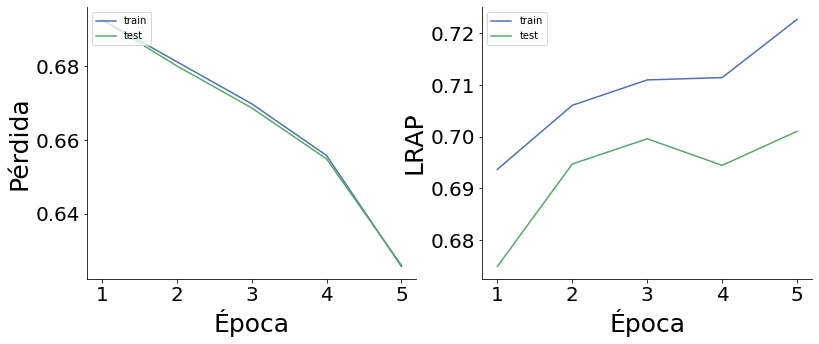

In [14]:
!nvidia-smi

loss_hist, lrap_hist = train(modelo_mel, train_dataloader, val_dataloader, 
                             lr=1e-3, epochs=5, model_name="conv-mel")

plot(loss_hist, lrap_hist, name="conv-mel")

In [60]:
lrap_hist[-1]

[0.7226905980844823, 0.7010170575421977]

### Predicción

In [42]:
test_recording_ids = [os.path.splitext(os.path.basename(path))[0]
                      for path in test_files_paths]
len(test_recording_ids)

1992

In [38]:
def predict(model, dl):
    # Usamos GPU, de ser posible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    batch_results = []
    with torch.no_grad():
        for batch in tqdm(dl):
            x = batch["spectrogram"].to(device)

            y_lgts = model(x)
            y_out = torch.sigmoid(y_lgts)
            
            batch_results.append(y_out)
            
        results = torch.vstack(batch_results).cpu().numpy()
    return results



In [39]:
test_dataset = RcsaDataset(test_files_paths, spec_type="mel", n_mels=64)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

predictions = predict(modelo_mel, test_dataloader)

100%|██████████| 498/498 [03:01<00:00,  2.74it/s]


In [57]:
df_sample_submission = pd.read_csv("../datos/sample_submission.csv")
df_submission = pd.DataFrame(predictions, index=test_recording_ids, 
                             columns=[f"s{i}" for i in range(NUM_SPECIES)])
df_submission = (df_submission.loc[df_sample_submission["recording_id"]]
                 .reset_index().rename(columns={"index":"recording_id"}))

display(df_sample_submission.head())
df_submission.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,003bc2cb2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0061c037e,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,010eb14d3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,011318064,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.494246,0.493937,0.494082,0.506638,0.510790,0.493453,0.504285,0.505463,0.509223,...,0.491638,0.499139,0.500070,0.489604,0.490643,0.509796,0.503879,0.504406,0.499228,0.497303
1,003bc2cb2,0.494541,0.492740,0.491190,0.506956,0.511719,0.492757,0.502485,0.504269,0.510300,...,0.489313,0.496997,0.499522,0.486349,0.493324,0.507800,0.502554,0.504116,0.497881,0.497088
2,0061c037e,0.493478,0.494534,0.494961,0.506502,0.509747,0.494509,0.505280,0.506268,0.507906,...,0.490883,0.499276,0.500244,0.489693,0.489522,0.510769,0.505437,0.504019,0.498916,0.497604
3,010eb14d3,0.691386,0.064638,0.085680,0.233746,0.074308,0.281049,0.133402,0.229760,0.241495,...,0.114712,0.315870,0.083152,0.082822,0.666652,0.157335,0.117032,0.026435,0.120651,0.323958
4,011318064,0.492355,0.496286,0.492682,0.511823,0.511770,0.491636,0.502328,0.504317,0.504913,...,0.496773,0.496076,0.495038,0.487462,0.489886,0.508504,0.500095,0.505365,0.498821,0.496440
